In [215]:
import numpy as np
import copy
import numpy.linalg as LA
import time
import random
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

# Part IV. Domain Adaptation Experiment

In [216]:
ambientDimension = 100
sigma = 0.5 # noise power
numAvg = int(1 * 1e+1) # number of average
base_train_num = 50

featureMean = np.zeros(ambientDimension)

# Testing Isotropic data 
a_test = 1
Cov1, Cov2 = np.identity(ambientDimension), np.identity(ambientDimension)
decay = .95
for i in range(ambientDimension):
    Cov1[i, i] = decay ** (i - 1)
for i in range(ambientDimension)[::-1]:
    Cov2[i, i] = decay ** (i - 1)
#for i in range(ambientDimension):
#    if i <= int(ambientDimension/2):
#        Cov1[i, i] = 0
#    else:
#        Cov2[i, i] = 0


featureCov = a_test * Cov1 + (1 - a_test) * Cov2
# sparse signal
#p = 0.2
#diag = np.diag(np.diag(featureCov))
#featureCov = (1 - p) ** 2 * (featureCov - diag) + (1 - p) * diag

#featureCov = np.identity(ambientDimension)
betaStar = np.random.multivariate_normal(featureMean, featureCov).reshape(-1,1)
betaStar /= LA.norm(betaStar)

#betaStar = np.ones([ambientDimension, 1])
#for i in range(ambientDimension):
#    if i <= int(ambientDimension/2):
#        betaStar[i, 0] = -1
#betaStar /= LA.norm(betaStar)

# sparsity
#for i in range(ambientDimension):
#    a = random.random()
#    if a <= 0.9:
#        betaStar[i] = 0
#betaStar /= LA.norm(betaStar)
        

# Nonisotropic data (comment this block if istropic data is used)
#featureCov = np.identity(ambientDimension)
#for i in range(ambientDimension):
#    if i <= int(ambientDimension/2):
#        featureCov[i,i] = 1
#betaStar =  np.zeros(ambientDimension).reshape(-1,1)
#betaStar[0] = 0.1
#betaStar[-1] = 1

# training data
train_mean = np.zeros(ambientDimension)
a_train = 1
#train_cov = np.identity(ambientDimension)
#for i in range(ambientDimension):
#    if i <= int(ambientDimension/2):
#        train_cov[i,i] = 0.2

In [217]:
# Estimator Functions
def getRidgeEst(X, y, yc, ridge):
    d = X.shape[1]
    n = X.shape[0]
    idm = np.identity(d)
    #for i in range(ambientDimension):
    #    if i <= int(ambientDimension/2):
    #        idm[i, i] = 0

    S = LA.pinv(X.T.dot(X) + n * ridge * idm).dot(X.T)
    return S.dot(y), S.dot(yc)

def getCropEst(X, y, yc, p):
    Cov = X.T.dot(X)
    d, n = X.shape[1], X.shape[0]
    diag = np.diag(np.diag(Cov))
    #Cov = n * featureCov
    a = 0
    Z = a * Cov + (1 - a) * ((1-p) * Cov + p * diag)
    
    #d, n = X.shape[1], X.shape[0]
    #ridge = 0.1
    #Z = Z + n * ridge * np.identity(d)
    
    S = LA.pinv(Z).dot((1 - p) * X.T)
    return S.dot(y), S.dot(yc) 

def get_crop_finite_iter(X, n0, n1, p):
    X0 = copy.deepcopy(X)
    x = X[n1 % n0, :] * bernoulli.rvs(1-p, size=ambientDimension)
    X0 = np.concatenate((X0, x.reshape(1, -1)), axis=0)
    return X0
    
def get_crop_finite_data(X, y, yc, n1, p):
    n0 = X.shape[0]
    X0 = copy.deepcopy(X)
    y0 = copy.deepcopy(y)
    yc_0 = copy.deepcopy(yc)
    for i in range(n1):
        x = X[i % n0, :] * bernoulli.rvs(1-p, size=ambientDimension)
        y1 = y[i % n0, :]
        y2 = yc[i % n0, :]
        X0 = np.concatenate((X0, x.reshape(1, -1)), axis=0)
        y0 = np.concatenate((y0, y1.reshape(1, -1)), axis=0)
        yc_0 = np.concatenate((yc_0, y2.reshape(1, -1)), axis=0)
    return X0, y0, yc_0

def getLSEst(X, y, yc):
    Cov = X.T.dot(X)
    #d = X.shape[1]
    # faster LSE approximation
    #est = LA.inv(Cov+1e-10*np.identity(d)).dot(X.T.dot(y))
    S = LA.pinv(Cov).dot(X.T)
    return S.dot(y), S.dot(yc)

def get_gauss_finite_data(X, y, yc, n1, ridge):
    n0 = X.shape[0]
    X0 = copy.deepcopy(X)
    y0 = copy.deepcopy(y)
    yc_0 = copy.deepcopy(yc)
    for i in range(n1):
        x = X[i % n0, :] + ridge * np.random.multivariate_normal(np.zeros(ambientDimension), np.identity(ambientDimension))
        y1 = y[i % n0, :]
        y2 = yc[i % n0, :]
        X0 = np.concatenate((X0, x.reshape(1, -1)), axis=0)
        y0 = np.concatenate((y0, y1.reshape(1, -1)), axis=0)
        yc_0 = np.concatenate((yc_0, y2.reshape(1, -1)), axis=0)
    return X0, y0, yc_0
    
def getFiniteCropEst(X, y, yc, k, p):
    mean_mask = getMask(k, p)
    Xb = X * mean_mask
    Cov_a = Xb.T.dot(Xb)
    Cov_a -= np.diag(np.diag(Cov_a))
    Cov = X.T.dot(X)
    diag = np.diag(Cov)
    diag = diag * mean_mask
    diag = np.diag(diag)
    Z = Cov_a + diag  
    S = LA.inv(Z).dot(Xb.T)
    return S.dot(y), S.dot(yc)

def getProjEst(X, y, yc, k):
    Cov = X.T.dot(X)
    d = X.shape[1]
    Z = (k+1)/d*Cov + 1/d*np.trace(Cov)*np.identity(d)
    S = LA.inv(Z).dot(X.T)
    return S.dot(y), S.dot(yc)

def getMixProjEst(X, y, k, a):
    Cov = X.T.dot(X)
    d = X.shape[1]
    Z = ((1-a)**2 + 2*a*(1-a)*k/d +a**2*(k**2+k)/d**2) * Cov
    Z += a**2*k/d**2*np.trace(Cov)*np.identity(d)
    est = LA.inv(Z).dot((1-a + a*k/d) * X.T.dot(y))
    return est

def getMixupEst(X, y, a):
    Cov = X.T.dot(X)
    n = X.shape[0]
    #d = X.shape[1]
    sumData = X.sum(axis=0).reshape(-1,1)
    sumY = y.sum()
    Z = (a+1)/(2*a+1)*Cov + a/(2*a+1)/n*sumData.dot(sumData.T)# + np.identity(d)
    Z1 = (a+1)/(2*a+1)*X.T.dot(y) + a/(2*a+1)/n*sumData*sumY
    return LA.pinv(Z).dot(Z1)

def getMixOTEst(X, y, a, P):
    Cov = X.T.dot(X)
    n = X.shape[0]
    Z = (a+1)/(2*a+1)/n*Cov + a/(4*a+2)*X.T.dot(P+P.T).dot(X)
    Z1 = (a+1)/(2*a+1)/n*X.T.dot(y) + a/(4*a+2)*X.T.dot(P+P.T).dot(y)
    return LA.pinv(Z).dot(Z1)

# Utility Functions

def getMask(k, p):
    mean_mask = 0
    for i in range(k):
        mean_mask += bernoulli.rvs(1-p, size=ambientDimension)
    return mean_mask / k

def sinkhornIter(K, niter):
    n = K.shape[0]
    ones = np.ones(n) / n
    a = np.ones(n) / n
    b = np.ones(n) / n
    for i in range(niter):
        b = ones / K.T.dot(a).reshape(-1)
        a = ones / K.dot(b).reshape(-1)
    return np.diag(a).dot(K).dot(np.diag(b))

def getRisk(betaTrue, betaEmp, noiseStd):
    mean = featureMean.reshape(-1,1)
    diff = betaTrue-betaEmp
    risk1 = diff.T.dot(featureCov + mean.dot(mean.T)).dot(diff)
    return risk1# + noiseStd**2    

def getExpRisk(numSampling, numIter, paraList, modeDA):
    risk = np.zeros([numIter, len(paraList)])
    variance = np.zeros([numIter, len(paraList)])
    bias = np.zeros([numIter, len(paraList)])
    riskLSE = np.zeros(numIter)
    biasLSE = np.zeros(numIter)
    varianceLSE = np.zeros(numIter)
            
    for t in range(numIter):
        # Draw training data / GMM
        X = np.zeros([numSampling, ambientDimension])
        for i in range(numSampling):
            a = random.random()
            if a <= a_train:
                X[i, :] = np.random.multivariate_normal(train_mean, Cov1)
            else:
                X[i, :] = np.random.multivariate_normal(train_mean, Cov2)
        X0 = X[:base_train_num, :] # base sample
        #X = np.random.multivariate_normal(train_mean, train_cov, numSampling)
        yc = X.dot(betaStar)
        yc_0 = yc[:base_train_num, :]
        # sparse noise
        #y = yc + (np.random.normal(0, sigma, numSampling) * np.random.binomial(n=1, size=numSampling, p=0.7)).reshape(-1,1)
        y = yc + np.random.normal(0, sigma, numSampling).reshape(-1,1)
        y0 = y[:base_train_num, :]
        # baseline LSE
        betaEst, betaEstClean = getLSEst(X, y, yc)
        riskLSE[t] = getRisk(betaStar, betaEst, sigma)
        biasLSE[t] = getRisk(betaStar, betaEstClean, sigma)
        varianceLSE[t] = getRisk(betaEst, betaEstClean, sigma) 
        
        for j in range(len(paraList)):
            if numSampling > base_train_num:
                n1 = numSampling - base_train_num
                if modeDA == "crop":
                    X1, y1, yc_1 = get_crop_finite_data(X0, y0, yc_0, n1, paraList[j])
                elif modeDA == "ridge":
                    X1, y1, yc_1 = get_gauss_finite_data(X0, y0, yc_0, n1, paraList[j]) 
            else:
                X1, y1, yc_1 = X, y, yc
           
            betaEst, betaEstClean = getLSEst(X1, y1, yc_1)
            risk[t, j] = getRisk(betaStar, betaEst, sigma)
            bias[t, j] = getRisk(betaStar, betaEstClean, sigma)
            variance[t, j] = getRisk(betaEst, betaEstClean, sigma)  
    return risk.mean(axis=0), bias.mean(axis=0), variance.mean(axis=0),\
            riskLSE.mean(), biasLSE.mean(), varianceLSE.mean()

In [218]:
# Choose the type of augmentation:
mode = "crop"
param = 0

# set range of parameters of DA
# "crop_finite": dropout with k fixed patterns, "crop": dropout with p dropout rate, 
# "ridge": add gaussian with power sigma s^2, "proj": random projection with k dimensional space,
# "mixup": mix-up with beta distribution parameter b
if mode == "ridge":
    params = np.power(2, np.linspace(-10, 10, num=5))
elif mode == "crop":
    upper = 0
    lower = -5
    params = np.power(2, np.linspace(lower, upper, num=5))
elif mode == "crop_finite":
    params = np.power(10, np.linspace(1, 2, 5)).astype(int)
elif mode == "proj":
    lowD = ambientDimension * (1-np.power(2, np.linspace(-4, -0.1 , 10)))
    params = [round(num) for num in lowD]
elif mode == "mixproj":
    params = np.power(2, np.linspace(-8, -1.5 , 10))
elif mode == "mixup":
    params = np.power(2, np.linspace(-3, 5 , 10))
elif mode == "mixOT":
    params = np.power(2, np.linspace(-3, 5 , 10))

In [219]:
sample = range(5, 6 * ambientDimension, 20)
riskList = list()
biasList = list()
varList = list()
riskLseList = list()
biasLseList = list()
varLseList = list()


# Simulate risk
np.random.seed(1)
count = 0
start = time.time()
for i in sample:
    a, b, c, d, e, f = getExpRisk(i, numAvg, params, mode)
    riskList.append(a)
    biasList.append(b)
    varList.append(c)
    riskLseList.append(d)
    biasLseList.append(e)
    varLseList.append(f)
    count += 1
    print('Complete {} %'.format(round(count*100/len(sample), 1)))
end = time.time()
print('Complete in {} sec'.format(round(end-start, 2)))

Complete 3.3 %
Complete 6.7 %
Complete 10.0 %
Complete 13.3 %
Complete 16.7 %
Complete 20.0 %
Complete 23.3 %
Complete 26.7 %
Complete 30.0 %
Complete 33.3 %
Complete 36.7 %
Complete 40.0 %
Complete 43.3 %
Complete 46.7 %
Complete 50.0 %
Complete 53.3 %
Complete 56.7 %
Complete 60.0 %
Complete 63.3 %
Complete 66.7 %
Complete 70.0 %
Complete 73.3 %
Complete 76.7 %
Complete 80.0 %
Complete 83.3 %
Complete 86.7 %
Complete 90.0 %
Complete 93.3 %
Complete 96.7 %
Complete 100.0 %
Complete in 205.55 sec


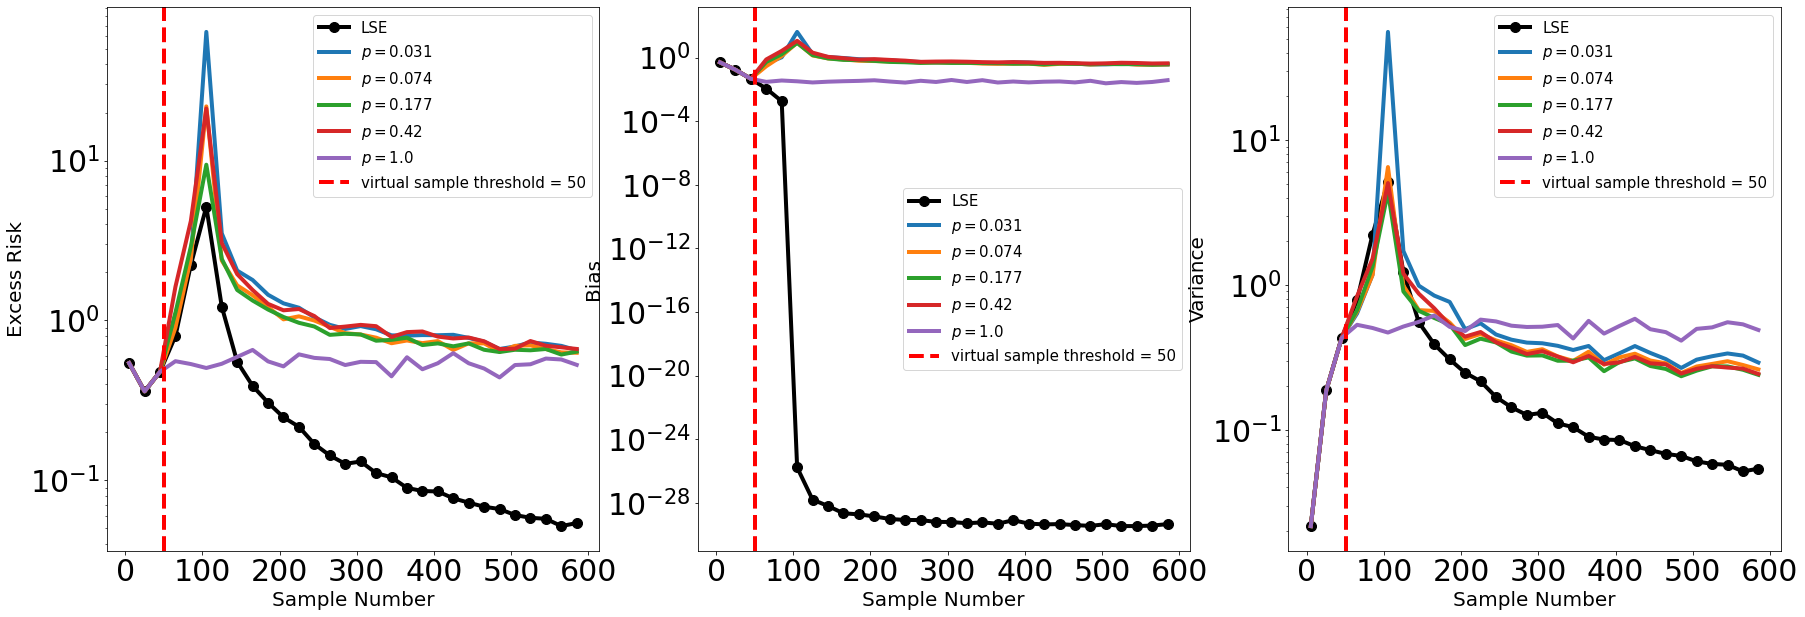

In [220]:
riskTable = np.zeros([len(sample),len(params)])
biasTable = np.zeros([len(sample),len(params)])
varTable = np.zeros([len(sample),len(params)])
for i in range(len(sample)):
    for j in range(len(params)):
        riskTable[i,j] = riskList[i][j]
        biasTable[i,j] = biasList[i][j]
        varTable[i,j] = varList[i][j]

plt.figure(figsize=(30, 10))
plt.subplot(1,3,1)
plt.plot(sample, riskLseList, label="LSE", color='black', marker='o', markersize=10, linewidth=4.0) 
for i in range(0, len(params)):
    if mode == "ridge":
        plt.plot(sample, riskTable[:,i],label=r'$\sigma=$'+str(round(np.sqrt(params[i]),3)), linewidth=4.0) # Gaussian noise
    elif mode == "crop":
        plt.plot(sample, riskTable[:,i],label=r'$p=$'+str(round(params[i],3)), linewidth=4.0) # Random crop
    elif mode == "crop_finite":
        plt.plot(sample, riskTable[:,i],label=r'$k=$'+str(round(params[i],3)), linewidth=4.0) # Random crop
    elif mode == "proj":
        plt.plot(sample, riskTable[:,i],label=r'$k=$'+str(round(params[i])), linewidth=4.0) # Random projection
    elif mode == "mixproj":
        plt.plot(sample, riskTable[:,i],label=r'$\alpha=$'+str(round(1-params[i], 3)), linewidth=4.0) # Random mixup projection    
    elif mode == "mixup":
        plt.plot(sample, riskTable[:,i],label=r'$\alpha=$'+str(round(params[i], 3)), linewidth=4.0) # Random mixup projection 
    elif mode == "mixOT":
        plt.plot(sample, riskTable[:,i],label=r'$\alpha=$'+str(round(params[i], 3)), linewidth=4.0) # OT + Random mixup projection
    plt.yscale("log")   
plt.axvline(x=base_train_num, label='virtual sample threshold = ' + str(base_train_num), c='red', ls='--', linewidth=4.0)
plt.legend(loc="upper right", prop={'size': 15})
plt.xlabel('Sample Number', fontsize=20)
plt.ylabel('Excess Risk', fontsize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#plt.ylim(1e-2,1e2)

plt.subplot(1,3,2)
plt.plot(sample, biasLseList,label="LSE", color='black', marker='o', markersize=10, linewidth=4.0) 
for i in range(0, len(params)):
    if mode == "ridge":
        plt.plot(sample, biasTable[:,i],label=r'$\sigma=$'+str(round(np.sqrt(params[i]),3)), linewidth=4.0) # Gaussian noise
    elif mode == "crop":
        plt.plot(sample, biasTable[:,i],label=r'$p=$'+str(round(params[i],3)), linewidth=4.0) # Random crop
    elif mode == "crop_finite":
        plt.plot(sample, biasTable[:,i],label=r'$k=$'+str(round(params[i],3)), linewidth=4.0) # Random crop
    elif mode == "proj":
        plt.plot(sample, biasTable[:,i],label=r'$k=$'+str(round(params[i])), linewidth=4.0) # Random projection
    elif mode == "mixproj":
        plt.plot(sample, biasTable[:,i],label=r'$\alpha=$'+str(round(1-params[i], 3)), linewidth=4.0) # Random mixup projection    
    elif mode == "mixup":
        plt.plot(sample, biasTable[:,i],label=r'$\alpha=$'+str(round(params[i], 3)), linewidth=4.0) # Random mixup projection 
    elif mode == "mixOT":
        plt.plot(sample, biasTable[:,i],label=r'$\alpha=$'+str(round(params[i], 3)), linewidth=4.0) # OT + Random mixup projection
    plt.yscale("log")   
plt.axvline(x=base_train_num, label='virtual sample threshold = ' + str(base_train_num), c='red', ls='--', linewidth=4.0)
plt.legend(loc="center right", prop={'size': 15})
plt.xlabel('Sample Number', fontsize=20)
plt.ylabel('Bias', fontsize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#plt.ylim(1e-2,1e0)

plt.subplot(1,3,3)
plt.plot(sample, varLseList,label="LSE", color='black', marker='o', markersize=10, linewidth=4.0) 
for i in range(0, len(params)):
    if mode == "ridge":
        plt.plot(sample, varTable[:,i],label=r'$\sigma=$'+str(round(np.sqrt(params[i]),3)), linewidth=4.0) # Gaussian noise
    elif mode == "crop":
        plt.plot(sample, varTable[:,i],label=r'$p=$'+str(round(params[i],3)), linewidth=4.0) # Random crop
    elif mode == "crop_finite":
        plt.plot(sample, varTable[:,i],label=r'$k=$'+str(round(params[i],3)), linewidth=4.0) # Random crop
    elif mode == "proj":
        plt.plot(sample, varTable[:,i],label=r'$k=$'+str(round(params[i])), linewidth=4.0) # Random projection
    elif mode == "mixproj":
        plt.plot(sample, varTable[:,i],label=r'$\alpha=$'+str(round(1-params[i], 3)), linewidth=4.0) # Random mixup projection    
    elif mode == "mixup":
        plt.plot(sample, varTable[:,i],label=r'$\alpha=$'+str(round(params[i], 3)), linewidth=4.0) # Random mixup projection 
    elif mode == "mixOT":
        plt.plot(sample, varTable[:,i],label=r'$\alpha=$'+str(round(params[i], 3)), linewidth=4.0) # OT + Random mixup projection
    plt.yscale("log") 
plt.axvline(x=base_train_num, label='virtual sample threshold = ' + str(base_train_num), c='red', ls='--', linewidth=4.0)
plt.legend(loc="upper right", prop={'size': 15})
plt.xlabel('Sample Number', fontsize=20)
plt.ylabel('Variance', fontsize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

#plt.ylim(1e-2,1e2)
plt.show()

In [221]:
betaStar.shape

(100, 1)

In [222]:
Cov2

array([[1.05263158, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.95      , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00726886, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00690541,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00656014]])

In [223]:
int((upper - lower) / 5)

1

In [224]:
riskList

[array([0.54095791, 0.54095791, 0.54095791, 0.54095791, 0.54095791]),
 array([0.35971964, 0.35971964, 0.35971964, 0.35971964, 0.35971964]),
 array([0.47704353, 0.47704353, 0.47704353, 0.47704353, 0.47704353]),
 array([1.09000434, 0.89983484, 1.11935202, 1.62477336, 0.55562828]),
 array([2.39294936, 2.44602928, 2.90500421, 4.19987104, 0.53304998]),
 array([63.89510467, 21.84768811,  9.42607533, 21.18833636,  0.50367385]),
 array([3.50833835, 2.37185605, 2.42875863, 3.05245233, 0.53522372]),
 array([2.04880864, 1.65578391, 1.5502905 , 1.94729256, 0.59088512]),
 array([1.78984547, 1.43625299, 1.33127416, 1.54974179, 0.65353302]),
 array([1.44688243, 1.21103774, 1.16938066, 1.26851244, 0.55396184]),
 array([1.27830979, 1.01521102, 1.05055621, 1.15654122, 0.51548333]),
 array([1.20070694, 1.06050463, 0.96606046, 1.17815829, 0.61307308]),
 array([1.04617607, 0.99794642, 0.9157916 , 1.06474171, 0.58269373]),
 array([0.93815968, 0.91146694, 0.81202773, 0.89611089, 0.57326979]),
 array([0.88431

In [225]:
riskLseList

[0.5409579110144062,
 0.35971963797004813,
 0.4770435296938465,
 0.7988705215167605,
 2.2340831389526543,
 5.149564761568297,
 1.2199278612448463,
 0.5506155536927746,
 0.38917698991804867,
 0.30566161905065686,
 0.24750603922977632,
 0.2159758120679069,
 0.16841200467965795,
 0.14281012681350558,
 0.1265553657433935,
 0.13092904232224217,
 0.11077635938337516,
 0.1042217337355891,
 0.08948904823691041,
 0.08557855406819108,
 0.08499023103024565,
 0.07700894732749684,
 0.07235423620397544,
 0.06820548943771153,
 0.06599567304074908,
 0.06053110496384043,
 0.05815652993083803,
 0.0573338094360474,
 0.05161187888827973,
 0.0539219990647104]